In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p ML
!google-drive-ocamlfuse ML
import os

os.chdir("ML/ML/datawhale/task3/") 

In [4]:
!pip install joblib
!pip install pandas
!pip install gbdt
!pip install xgboost
!pip install lightgbm
!pip install imbalanced-learn

    100% |████████████████████████████████| 3.1MB 9.0MB/s 
  Running setup.py bdist_wheel for gbdt ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e1/4e/77/9269956665f9f92ebb16eec5029c5dc5ac98be513a3a649c1b
Successfully built gbdt


# accuracy、precision、recall、F1-score、auc

## 1、公式介绍

![1](./111.jpg)

### accuracy=$\frac{1}{m} \sum_{i=1} ^m 1(f(x_i) = y_i)$

###  查准率(P)：precision=$ \frac{TP}{TP+FP}$  

### 查全率(R)：recall=$\frac{TP}{TP+FN}$  

### F1-score= $2 * \frac{P * R}{P + R}$  

### acu:ROC曲线的面积大小

## 2、note

### 1、查准率与查全率是一对互相矛盾的值。按照预测结果对模型排序，预测结果好的排在前面，不好的排在后面。以查准率为纵轴，查全率为横轴，成为P-R曲线。若模型A的PR曲线包含了模型C，那么A的模型优于模型C   

### 2、若模型A与模型C的PR曲线相交，那么通过比较相对应的PR曲线面积的大小判断模型优劣。但因为面积较难求出，所以同其他方式。F1-score即通过求查全率与查准率相等的点：$$\frac{1}{F1}=\frac{1}{2} * (\frac{1}{P} + \frac{1}{R})$$  
推出 $$F_1 = \cfrac{2 * P * R}{P + R}$$

### 3、实际中优于对查准率与查全率的重视程度不一样。F1-score转变为$F_\beta$。 
$$\cfrac{1}{F_\beta} = \cfrac{1}{1 + \beta^2}*(\cfrac{1}{P} + \cfrac{\beta^2}{R})$$  
推出 $$F_{\beta} = \cfrac{(1+ \beta^2) * P * R}{(\beta^2 * P) + R}$$   
$$\beta=1时，退化为F1；\beta>1时查全率有更大的影响；\beta<1时查准率有更大的影响$$   

### 4、当在n个二分类混淆矩阵上综合考察查准率和查全率时：  
#### 4.1宏查全率(宏F1):在各个混淆矩阵上分别计算出插住率和查全率，记为$(P_1,R_1),..(P_n, R_n)$，再计算平均值得到：
$$macroP=\cfrac{1}{n} \sum_{i=1}^n P_i$$  

$$macroR=\cfrac{1}{n} \sum_{i=1}^n R_i$$  

$$macroF1=\cfrac{2 * macroP * macroR}{macroP + macroR}$$  

#### 4.2先将各混淆矩阵的对应元素取平均，得到$\overline{TP}、\overline{FP}、\overline{TN}、\overline{FN}$  
$$microP=\cfrac{\overline{TP}}{\overline{TP} + {\overline{FP}}}$$  
$$microR=\cfrac{\overline{TP}}{\overline{TP} + {\overline{FN}}}$$  
$$microF1=\cfrac{2 * microP * microR}{microP + microR}$$  

### 5、AUC  
$$真正例率(TPR)=\cfrac{TP}{TP + FN}$$
$$假正例率(FPR)=\cfrac{FP}{TP + FP}$$
#### 5.1、ROC曲线是以TPR为纵轴，以FPR为横轴。对于$m^{+}$个正例和$m^{-}$个负例，当阈值设置很高时，TPR和FPR都为0，则在原点标记一个点。然后将分类阈值设置为每一个样例的预测值，即依次将每个样例划分为正例，设前一个标记点坐标为(x,y)，当前为真正例，对应的坐标为$(x, y + \frac{1}{m^{+}})$;当前为假正例，则对应的标记点的坐标为$(x + \frac{1}{m^{+}}, y)$，最后用线连接起来。  


#### 5.2、AUC等于ROC曲线的面积。即  
$$AUC = \cfrac{1}{2} \sum_{i=1}^{m-1} (x_{i+1}-x_i) * (y_i + y_{i+1})$$  
AUC考虑的是样本预测的排序质量，因此与排序误差紧密联系。给定$m^{+}$个正例和$m^{-}$个反例，令$D^{+}$和$D^{-}$表示正例、反例集合。若正例的预测值小于反例，惩罚项为1， 若相等则为0.5则排序损失定义为  
$$l_{rank} = \cfrac{1}{m^{+} m^{-}} \sum_{x^{+} \in D^{+}} \sum_{x^{-} \in D^{-}} (I(f(x^{+}) < f(x_{-}) + 
 \frac{1}{2} I(f(x^{+}) = f(x_{-}))$$  
 
其中 $\_{rank}$对应于ROC曲线之上的面积
若一个正例在ROC曲线上对应的标记点坐标为(x, y)，则x恰是排序在其之前的反例所占的比例。因此有  $$AUC = 1 - l_{rank}$$

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import time
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('../data_all.csv')
y_data = pd.DataFrame(data['status']).values.ravel()
x_data = data.drop(columns='status').values

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=2018)
print(data.shape)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4754, 85)
(3327, 84) (3327,) (1427, 84) (1427,)


In [0]:
def show_plt_metric(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train)
  y_valid = model.predict(x_test)
  y_valid_proba = (model.predict_proba(x_test))[:, 1]
  
  #精确度
  accurate = metrics.accuracy_score(y_test, y_valid)
  print("精确度:", accurate)
  
  #召回率
  recall = metrics.recall_score(y_test, y_valid)
  print("召回率:", recall)
  
  #F1-score
  f1score = metrics.f1_score(y_test, y_valid)
  print("F1-score:", f1score)
  
  #AUC
  auc = metrics.roc_auc_score(y_test, y_valid_proba)
  print("AUC:", auc)
  
  #ROC plot
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_valid_proba)
  plt.plot(fpr, tpr)
  plt.plot([0,1], [0,1],"--")
  plt.title("ROC")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend(labels=[" AUC:"+str(round(auc,5))], loc="lower right")
  plt.show()

# LR

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


精确度: 0.6902592852137351
召回率: 0.5988857938718662
F1-score: 0.4931192660550458
AUC: 0.729580712132119


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


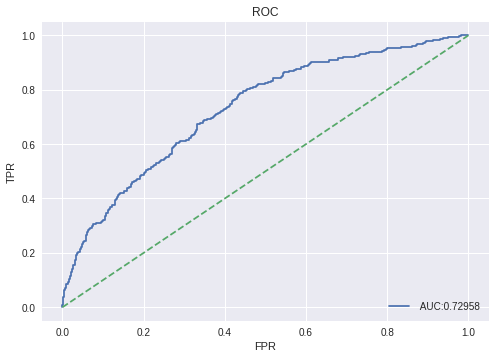

LR训练结束,耗时:0.03702821731567383min


In [27]:
t_start = time.time()

lr = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=100, random_state=2018)

show_plt_metric(lr, x_train, y_train, x_test, y_test)

#joblib.dump(lr, 'lr_model.m')

t_end = time.time()
print('LR训练结束,耗时:{}min'.format((t_end - t_start) / 60))

# SVM

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


精确度: 0.7484232655921513
召回率: 0.0
F1-score: 0.0
AUC: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


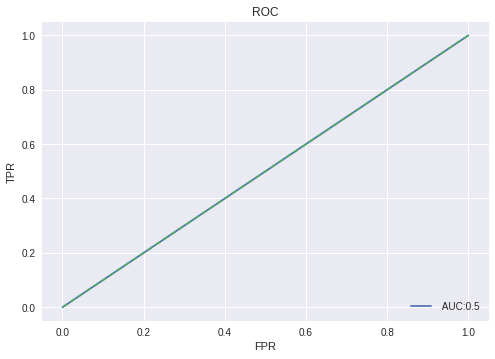

SVM训练结束,耗时:0.1918842633565267min


In [28]:
t_start = time.time()

svc = SVC(class_weight='balanced', probability=True, random_state=2018)

show_plt_metric(svc, x_train, y_train, x_test, y_test)

#joblib.dump(svc, 'svc_model.m')

t_end = time.time()
print('SVM训练结束,耗时:{}min'.format((t_end - t_start) / 60))

# Tree

精确度: 0.6951646811492642
召回率: 0.5793871866295265
F1-score: 0.4888366627497063
AUC: 0.6924665894651184


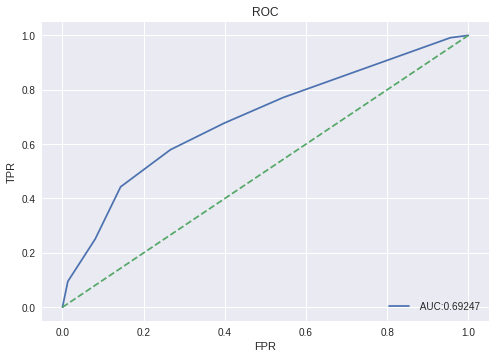

Tree训练结束,耗时:0.002822319666544596min


In [29]:
t_start = time.time()

dtree = DecisionTreeClassifier(max_depth=30, min_samples_split=3, max_features='log2', random_state=2018, \
                               max_leaf_nodes=8, class_weight='balanced')
show_plt_metric(dtree, x_train, y_train, x_test, y_test)

#joblib.dump(dtree, 'dtree_model.m')
t_end = time.time()
print('Tree训练结束,耗时:{}min'.format((t_end - t_start) / 60))

# RF

精确度: 0.767344078486335
召回率: 0.5766016713091922
F1-score: 0.5549597855227882
AUC: 0.7773648190458307


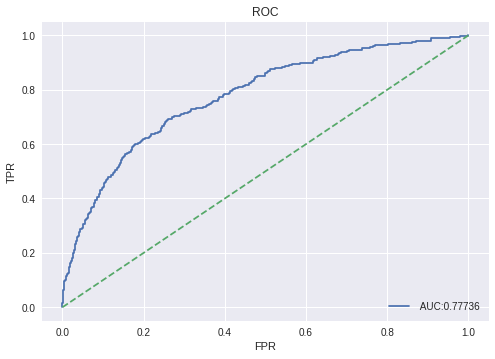

rf 训练结束,耗时:0.0773324211438497min


In [30]:
t_start = time.time()

rf = RandomForestClassifier(n_estimators=190, max_features=0.3, max_depth=10, min_samples_split=2, 
                            min_samples_leaf=2, class_weight='balanced', max_leaf_nodes=70, random_state=2018)

show_plt_metric(rf, x_train, y_train, x_test, y_test)

#joblib.dump(rf, 'rf.m')

t_end = time.time()
print('rf 训练结束,耗时:{}min'.format((t_end - t_start) / 60))

# GDBT

精确度: 0.7883672039243167
召回率: 0.3342618384401114
F1-score: 0.44280442804428044
AUC: 0.7694229705903831


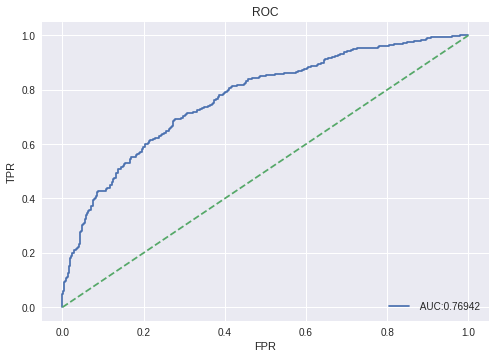

gdbt 训练结束,耗时:0.009556758403778075min


In [32]:
t_start = time.time()

gdbt = GradientBoostingClassifier(loss='exponential', n_estimators=100, max_depth=3,  max_features=0.2, 
                                  min_samples_leaf=4, random_state=2018)

show_plt_metric(gdbt, x_train, y_train, x_test, y_test)
#joblib.dump(gdbt, 'gdbt.m')

t_end = time.time()
print('gdbt 训练结束,耗时:{}min'.format((t_end - t_start) / 60))

# xgb

精确度: 0.775052557813595
召回率: 0.35097493036211697
F1-score: 0.43979057591623033
AUC: 0.7504955504783366


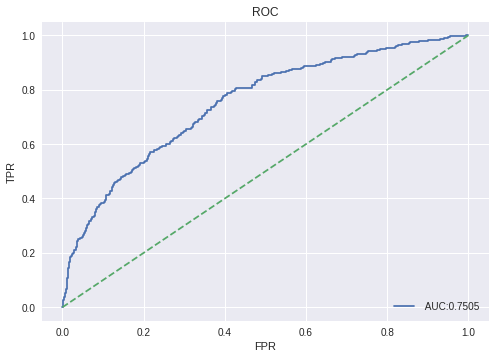

xgb训练结束,耗时:0.014339975516001384min


In [34]:
t_start = time.time()

xgbClassify = xgb.XGBClassifier(max_depth=10, n_estimators=20, silent=1, booster='gbtree', 
                                     gamma=0.5, subsample=0.5,random_state=2018)

show_plt_metric(xgbClassify, x_train, y_train, x_test, y_test)

#joblib.dump(xgbClassify, 'xgbClassify_model.m')
t_end = time.time()
print('xgb训练结束,耗时:{}min'.format((t_end - t_start) / 60))

# lgb

精确度: 0.7701471618780659
召回率: 0.35097493036211697
F1-score: 0.43448275862068964
AUC: 0.7574019592501017


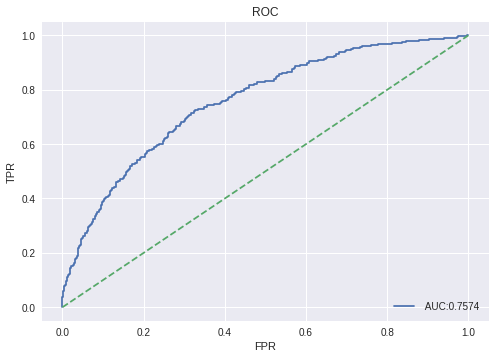

lgb训练结束,耗时:0.016496256987253825min


In [35]:
t_start = time.time()

lgbClassify = lgb.LGBMClassifier()

show_plt_metric(lgbClassify, x_train, y_train, x_test, y_test)

#joblib.dump(lgbClassify, 'lgbClassify_model.m')
t_end = time.time()
print('lgb训练结束,耗时:{}min'.format((t_end - t_start) / 60))